In [1]:
import sys, os
sys.path.append(os.path.abspath(
    os.getcwd()+"/src")
)

In [4]:
from qecsim.models.rotatedplanar import RotatedPlanarCode, RotatedPlanarPauli, RotatedPlanarRMPSDecoder
from src.ModifiedRotatedPlanarRMPSDecoder import ModifiedRotatedPlanarRMPSDecoder
from src.data_gen import noise_permutations_from_deformation, sample_errors
from qecsim.models.generic import BiasedDepolarizingErrorModel
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax import random

key = random.key(42)

In [9]:
deformation = jnp.array([
    [0,0,0],
    [0,1,2],
    [3,4,5]
])
noise_permutations_from_deformation(deformation)

Array([[[0, 1, 2, 3],
        [0, 1, 2, 3],
        [0, 1, 2, 3]],

       [[0, 1, 2, 3],
        [0, 2, 1, 3],
        [0, 1, 3, 2]],

       [[0, 3, 2, 1],
        [0, 2, 3, 1],
        [0, 3, 1, 2]]], dtype=int32)

In [6]:
L = 3 # Surface code distance
chi = 6 # bond dimension
eta = 500 # bias
error_probability = 0.1 # physical error rate

code = RotatedPlanarCode(L, L)
n, k, d = code.n_k_d

regular_decoder = RotatedPlanarRMPSDecoder(chi)
modified_decoder = ModifiedRotatedPlanarRMPSDecoder(chi)

error_model = BiasedDepolarizingErrorModel(bias=eta, axis='Z')

# deformation = 2*jnp.ones((L, L), dtype=int)  # Turn it into the XY-surface code this excells at high Z-bias
deformation = jnp.zeros((L, L), dtype=jnp.int32).at[1::2, ::2].set(3).flatten().at[::2].set(2).reshape((L, L)) # C1 deformation generalized
# deformation = np.random.randint(0, 6, size=(L, L))  # Random deformation
noise_permutations = noise_permutations_from_deformation(deformation)
print(deformation)

logicals_to_pauli = [['I', 'Z'], ['X', 'Y']]

[[2 0 2]
 [3 2 3]
 [2 0 2]]


In [ ]:
test_count = 1000

regular_decoder_results = {'I': 0, 'X': 0, 'Y': 0, 'Z': 0}
modified_decoder_results = {'I': 0, 'X': 0, 'Y': 0, 'Z': 0}

for i in range(test_count):
    print(f"Test {i + 1}/{test_count}", end='\r')
    subkey, key = random.split(key)

    error = sample_errors(subkey, code, error_model, error_probability, noise_permutations)
    syndrome = code.stabilizers @ error % 2
    error_logical = code.logicals @ error % 2
    
    regular_recovery_ = regular_decoder.decode(code, syndrome, error_model, error_probability)
    modified_recovery_ = modified_decoder.decode(code, syndrome, error_model, error_probability, noise_permutations)

    # Swap X and Z parts of the recovery to match the deformation convention (should not be needed)
    regular_recovery = jnp.zeros_like(regular_recovery_)
    modified_recovery = jnp.zeros_like(modified_recovery_)
    regular_recovery = regular_recovery.at[:n].set(regular_recovery_[n:])
    regular_recovery = regular_recovery.at[n:].set(regular_recovery_[:n])
    modified_recovery = modified_recovery.at[:n].set(modified_recovery_[n:])
    modified_recovery = modified_recovery.at[n:].set(modified_recovery_[:n])

    regular_recovery_logical = (code.logicals @ regular_recovery) % 2
    regular_logical_error = (error_logical + regular_recovery_logical) % 2
    modified_recovery_logical = (code.logicals @ modified_recovery) % 2
    modified_logical_error = (error_logical + modified_recovery_logical) % 2

    regular_decoder_results[logicals_to_pauli[regular_logical_error[0]][regular_logical_error[1]]] += 1
    modified_decoder_results[logicals_to_pauli[modified_logical_error[0]][modified_logical_error[1]]] += 1

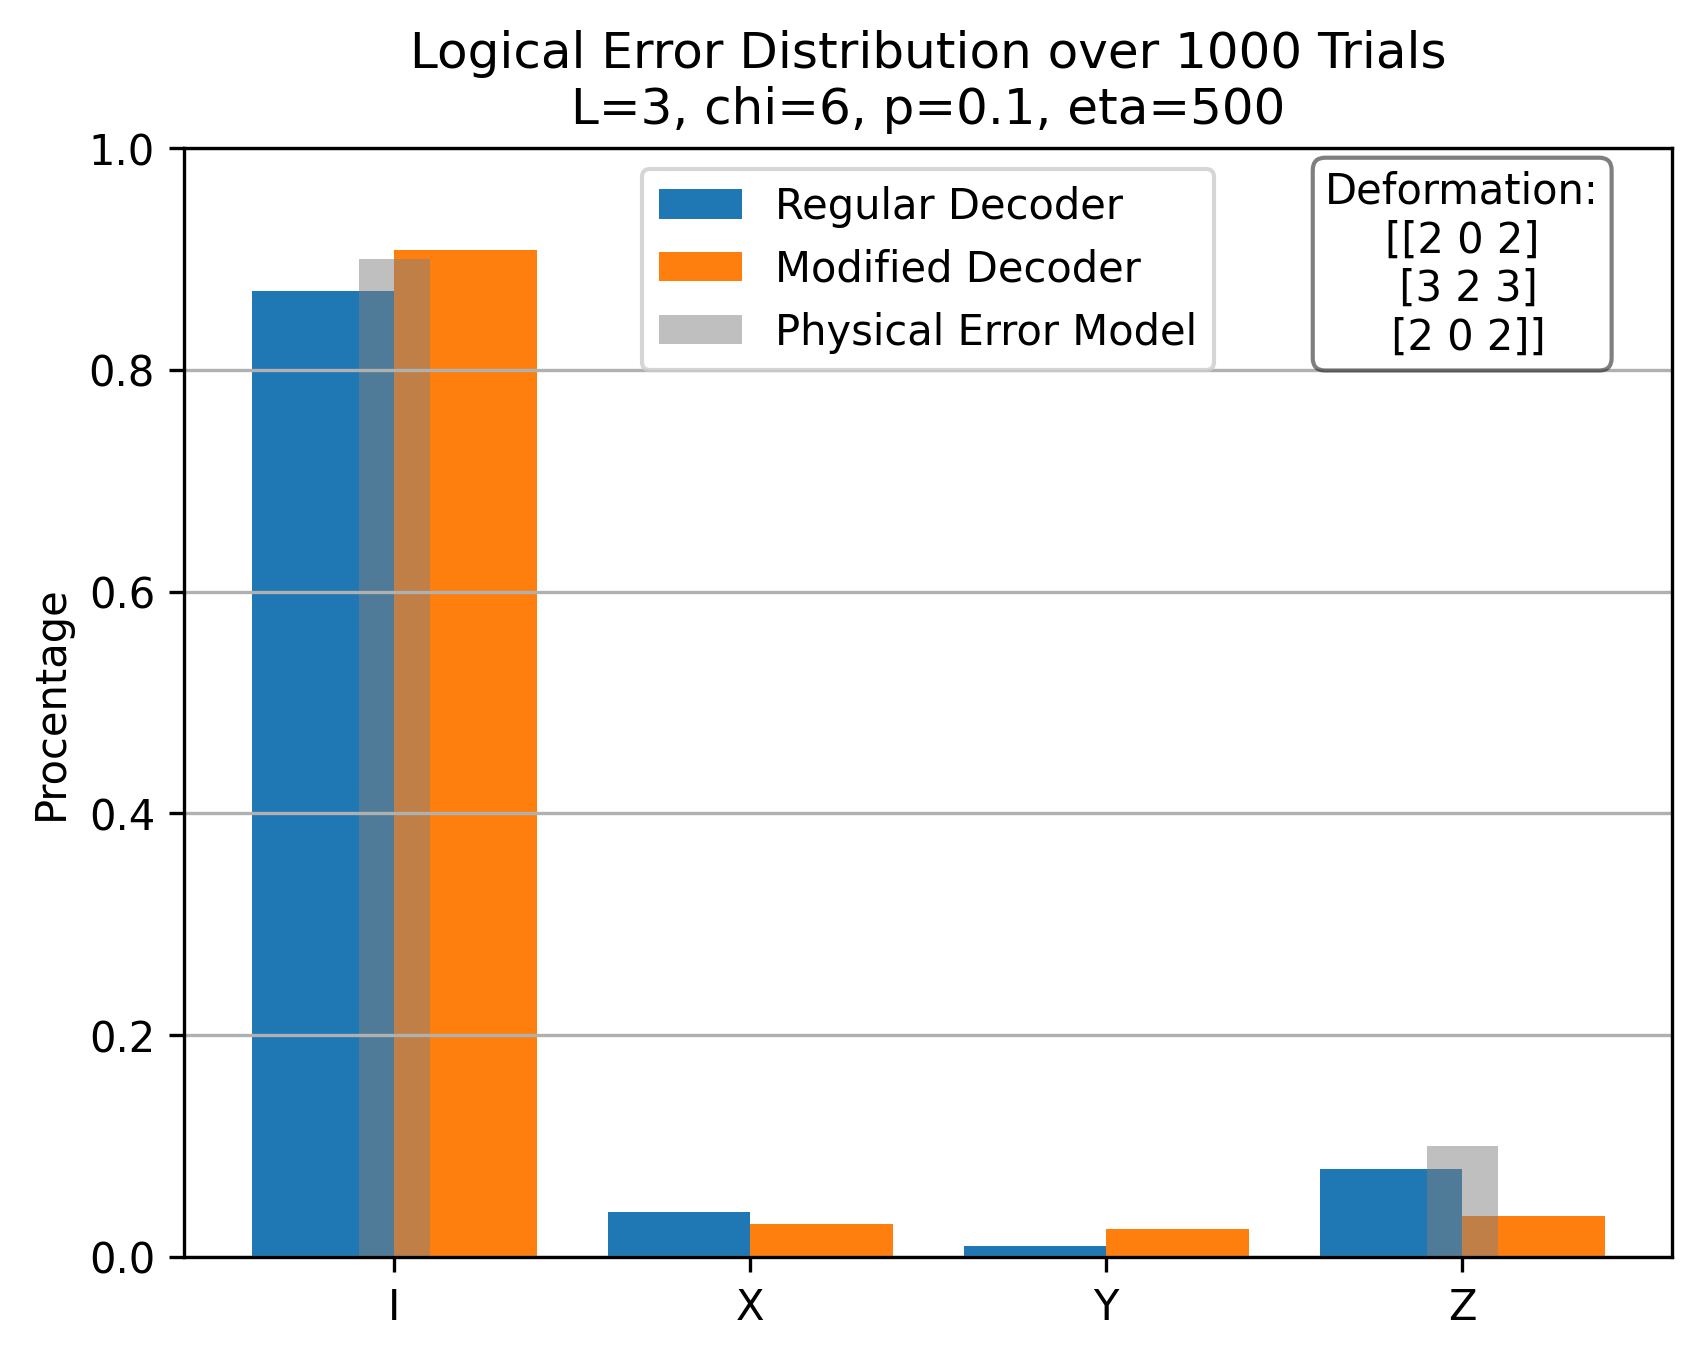

In [8]:
plt.figure(dpi=300)
plt.bar(jnp.arange(4)-0.2, [regular_decoder_results[p]/test_count for p in ['I', 'X', 'Y', 'Z']], width=0.4, label='Regular Decoder')
plt.bar(jnp.arange(4)+0.2, [modified_decoder_results[p]/test_count for p in ['I', 'X', 'Y', 'Z']], width=0.4, label='Modified Decoder')
plt.bar(jnp.arange(4), error_model.probability_distribution(error_probability), width=0.2, label='Physical Error Model', color='gray', alpha=0.5)
plt.xticks(jnp.arange(4), ['I', 'X', 'Y', 'Z'])
plt.ylabel('Procentage')
plt.title(f'Logical Error Distribution over {test_count} Trials\nL={L}, chi={chi}, p={error_probability}, eta={eta}')
plt.text(3, 0.98, f'Deformation:\n{deformation}', ha='center', va='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
plt.legend(loc='upper center')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()